In [15]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from specutils.fitting import fit_generic_continuum
from specutils.spectra import Spectrum1D, SpectralRegion

In [2]:
from scipy.signal import medfilt

## things to do

- first continuum subtraction + removal of background noise
- find emission peaks
- find relative strengths of each peak + error
- handle double peaks with care
- correct for redshift
- find chemical abundance from a database (atomic database?)
$$
f_\text{corr} = f_\text{obs}(1+z)\\
f[i] = \text{median}(f[i-1],f[i],f[i+1])
$$

In [2]:
z = 0.017670
lambda_, intensity = np.loadtxt('ngc1275.csv', delimiter=',', unpack = True, usecols = (0,1)) # Angstrom, W / (m^2 Hz)
lambda_ /= 1+z
frequency = (299792458/lambda_)*0.01 # THz

<QuantityModel Chebyshev1D(3, c0=-6.37124029, c1=0.00379377, c2=-0.00000033, c3=0.), input_units=Angstrom, return_units=Jy> [3586.62434777 3588.58962139 3590.55489501 ... 6972.7907868  6974.75606041
 6976.72133403] [0.4498 0.4498 0.4498 ... 1.4085 1.4101 1.4101]
<QuantityModel Chebyshev1D(3, c0=-6.37124029, c1=0.00379377, c2=-0.00000033, c3=0.), input_units=Angstrom, return_units=Jy>


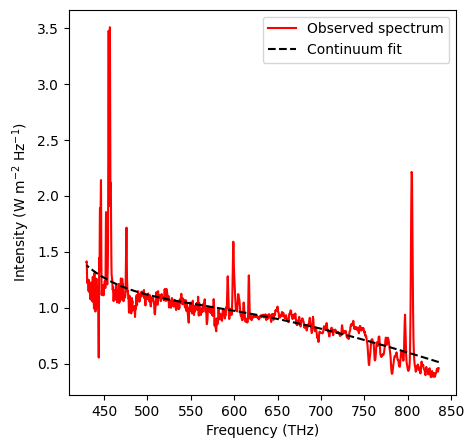

In [3]:
plt.figure(figsize=(5,5))
spectrum = Spectrum1D(flux=intensity*u.Jy, spectral_axis=lambda_*u.angstrom)
g1_fit = fit_generic_continuum(spectrum)
y_continuum_fitted = g1_fit(lambda_*u.angstrom)
flux = intensity*u.Jy-y_continuum_fitted
# flux = intensity/y_continuum_fitted
plt.plot(frequency, intensity, 'r', label='Observed spectrum')  
plt.plot(frequency, y_continuum_fitted, 'k--', label='Continuum fit')
plt.xlabel('Frequency (THz)')
plt.ylabel('Intensity (W m$^{-2}$ Hz$^{-1}$)')
plt.legend()

$$
P(x) = \sum_{i=0}^{i=n}C_{i} * T_{i}(x)
$$

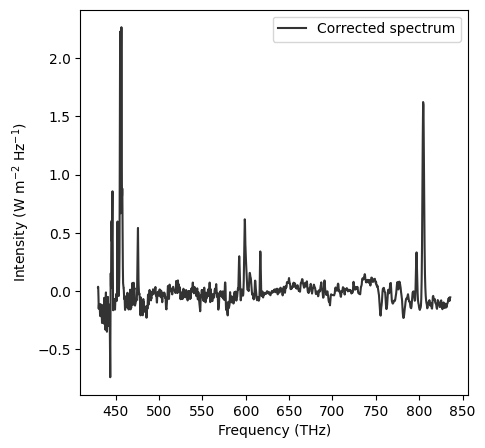

In [123]:
plt.figure(figsize=(5,5))
# flux*u.Jy+1
# plt.plot(frequency, flux*u.Jy-1, 'k')  
plt.plot(frequency, flux, 'k', alpha=0.8, label='Corrected spectrum')  
plt.xlabel('Frequency (THz)')
plt.ylabel('Intensity (W m$^{-2}$ Hz$^{-1}$)')
plt.legend()

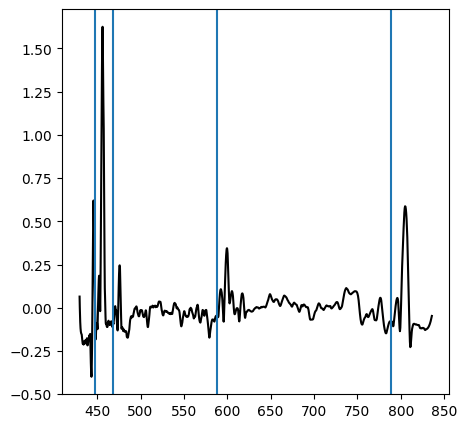

In [124]:
plt.figure(figsize=(5,5))
from scipy.signal import savgol_filter
fluxs = savgol_filter(flux, 30, 3)
spectrumf = Spectrum1D(flux=fluxs*u.Jy, spectral_axis=lambda_*u.angstrom)
plt.plot(frequency, fluxs, 'k')  
plt.axvline((299792458/3800)*0.01)
plt.axvline((299792458/5100)*0.01)
plt.axvline((299792458/6400)*0.01)
plt.axvline((299792458/6700)*0.01)

In [125]:
from specutils.fitting import find_lines_derivative
lines = find_lines_derivative(spectrumf, flux_threshold=0.25)  
ls = lines[lines['line_type'] == 'emission']
ls['line_center']

<Quantity [3722.22822722, 4999.65607712, 6569.90969568, 6725.16631128] Angstrom>

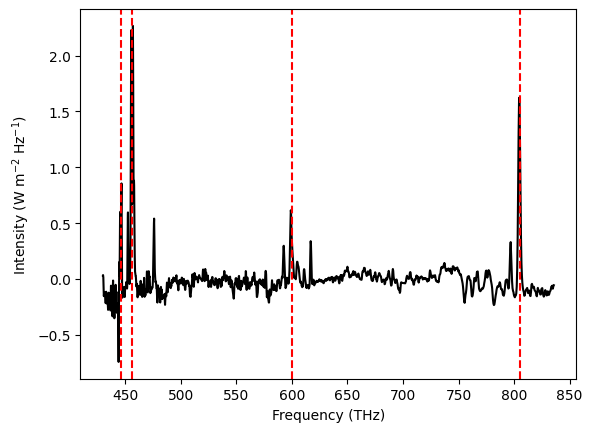

In [126]:
plt.plot(frequency, flux, 'k', alpha=1, label='Corrected spectrum')  
plt.xlabel('Frequency (THz)')
plt.ylabel('Intensity (W m$^{-2}$ Hz$^{-1}$)')
plt.axvline((299792458/3722.2282)*0.01, color='r', linestyle='--')
plt.axvline((299792458/4999.6561)*0.01, color='r', linestyle='--')
plt.axvline((299792458/6569.9097)*0.01, color='r', linestyle='--')
plt.axvline((299792458/6725.1663)*0.01, color='r', linestyle='--')
# plt.legend()

In [127]:
flux

<Quantity [-0.05524473, -0.06576258, -0.08647865, ...,  0.03125408,
            0.03595379,  0.03125209] Jy>

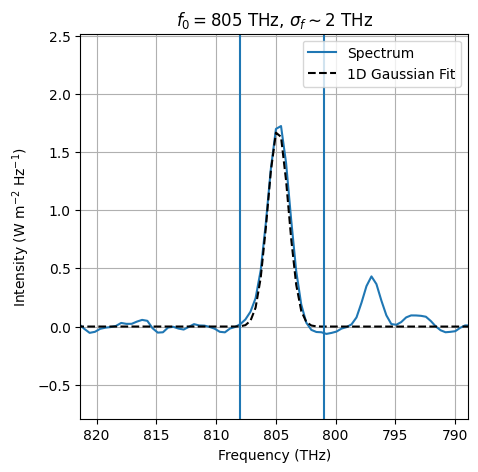

In [135]:
from specutils.fitting import fit_lines
from astropy.modeling import models
g_init = models.Gaussian1D(amplitude=1.7*u.Jy, mean=3725*u.Angstrom, stddev=4.*u.Angstrom)
spectrum =  Spectrum1D(flux=savgol_filter(flux, 30, 5)*u.Jy, spectral_axis=lambda_*u.angstrom)
g_fit = fit_lines(spectrum, g_init, window=(6200*u.Angstrom, 6800*u.Angstrom))
y_fit = g_fit(lambda_*u.Angstrom)
plt.figure(figsize=(5,5))

plt.plot(frequency, flux/u.Jy+0.1, label='Spectrum')
plt.plot(frequency, y_fit, 'k--', label='1D Gaussian Fit')
plt.title('$f_{0}=805$ THz, $\sigma_f \sim 2$ THz')
plt.grid(True)
plt.xlim((299792458/3650)*0.01,(299792458/3800)*0.01)
# plt.ylim(-0.5,2)
plt.xlabel('Frequency (THz)')
plt.ylabel('Intensity (W m$^{-2}$ Hz$^{-1}$)')
plt.legend()
plt.axvline(808)
plt.axvline(801)

$$
\text{Strength}_{f} = \sqrt{\frac{\pi}{\sigma_f}} 
$$

In [129]:
(299792458/4)*0.01

749481.145

In [130]:
u.Angstrom

Unit("Angstrom")

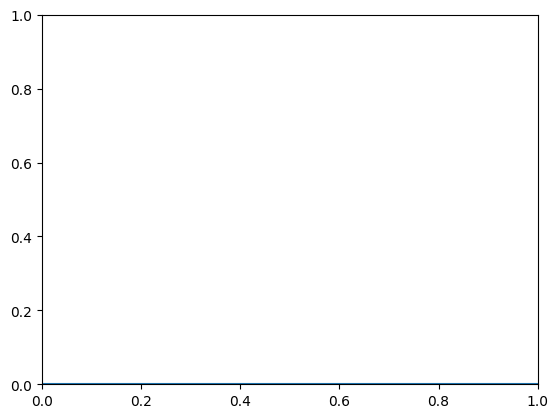

In [131]:
# a, b = 20, 130
# plt.plot(lambda_[a:b], flux[a:b]) 
# a, b = 1400, 1630
# plt.plot(lambda_[a:b], flux[a:b]) 
plt.axhline(0)

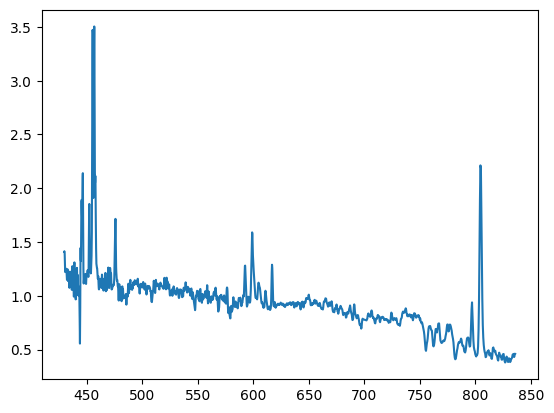

In [132]:
plt.plot(frequency, intensity)

# Step I: Continuum Subtraction

In [16]:
z = 0.0#17670
lambda_, intensity = np.loadtxt('ngc1275.csv', delimiter=',', unpack = True, usecols = (0,1)) # Angstrom, W / (m^2 Hz)
lambda_ /= 1+z
frequency = (299792458/lambda_)*0.01 # THz

In [17]:
from scipy import ndimage
ndimage.maximum_filter1d
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.modeling.polynomial import Chebyshev1D


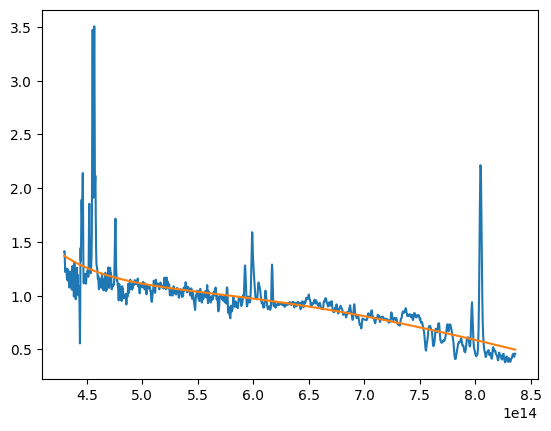

In [ ]:
from scipy.constants import h, c, k, pi
from scipy.optimize import curve_fit
def plank(f, T):
    # pi = np.pi
    # h=6.626e-34
    # c=299792458
    return (2 * pi * h * f**3) / (c**2 * (np.exp((h * f) /(k * T)) - 1))


    

# xs = np.linspace(100e12, 1000e12, 1000)
smoothedd = medfiltt(intensity, 3)
ys = plank(frequency*1e12, 7000)
fits = curve_fit(plank, frequency*1e12, smoothedd, p0=6000)
T = fits[0]
# yfit = plank(frequency*1e12, T)
yfit = conti(lambda_, smoothedd)(lambda_)
# plt.plot(frequency*1e12, ys/max(ys))
plt.plot(frequency*1e12, intensity)
plt.plot(frequency*1e12, yfit)
# plt.plot(frequency*1e12, yfit/max(yfit))
# yfit(lambda_)

[792.6823321  792.26336681 791.84484416 449.19457297] [3782. 3784. 3786. 6674.]


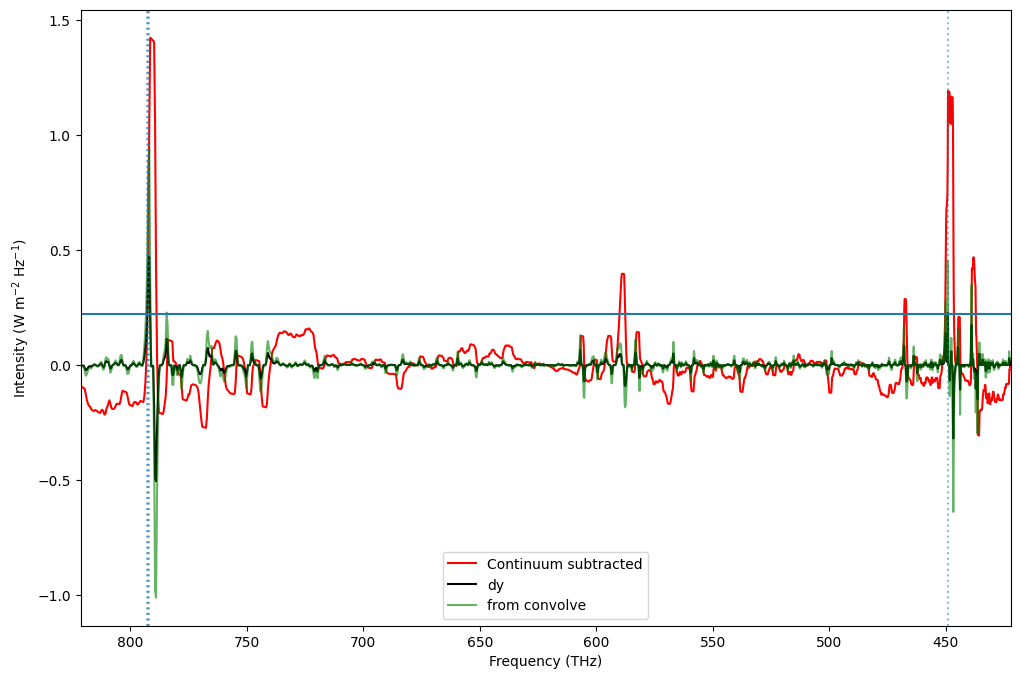

In [ ]:
from scipy.signal import convolve
from scipy.signal import find_peaks as fp

def medfiltt(x, k=5):
    n = len(x)
    xs = np.zeros(n)
    for i in range(n):
        a = i-5 if i >= 5 else 0
        b = i+5 if i <= n-5 else -1 
        xs[i] = np.median(x[a:b])
    return xs

def continuum_fit(f, I, model=Chebyshev1D(3), fitter=LevMarLSQFitter(calc_uncertainties=True)):
    fit_model = fitter(model, f, I, weights=None)
    return fit_model

def find_lines(f, I):
    # h = f[1]-f[0]
    dy = np.zeros(len(I))
    for i in range(1, len(I)-1):
        dy[i] = (I[i+1]-I[i-1])/2
    return dy[:]

def find_peaks():
    smoothedd = medfiltt(intensity, 3)
    continuum = continuum_fit(lambda_, smoothedd)(lambda_)
    continuum_subtracted = smoothedd/continuum - 1

    kernel = [1, 0, -1]
    dY = convolve(continuum_subtracted, kernel, 'valid')

    dy = find_lines(frequency, continuum_subtracted)
    threshold = 0.22
    line_fs = frequency[np.where(dy>threshold)]
    print(line_fs, lambda_[np.where(dy>threshold)])

    plt.figure(figsize=(12, 8))

    # plt.plot(frequency, intensity, 'b', label='Observed spectrum', alpha=0.6)  
    # plt.plot(frequency, smoothedd, 'r', label='Median Smoothened')  
    # plt.plot(frequency, continuum, 'k', label='Continuum fit')
    plt.plot(frequency, continuum_subtracted, 'r', label='Continuum subtracted')
    plt.plot(frequency, dy, 'k', label='dy')
    plt.plot(frequency[1:-1], dY, 'g', label='from convolve', alpha=0.6)
    plt.axhline(threshold)
    peaks, _ = fp(continuum_subtracted, height=threshold)
    plt.plot(peaks, continuum_subtracted[peaks], "x")

    for line in line_fs:
        plt.axvline(line, linestyle=':', alpha=0.5)
        
    # for line in [3722.2282, 4999.6561, 6569.9097, 6725.1663]:
    #     plt.axvline((299792458/line)*0.01, color='violet')

    plt.xlabel('Frequency (THz)')
    plt.ylabel('Intensity (W m$^{-2}$ Hz$^{-1}$)')
    plt.xlim(frequency[0], frequency[-1])
    plt.legend()
    return continuum_subtracted, line_fs

intensity_corr, line_fs = find_peaks()

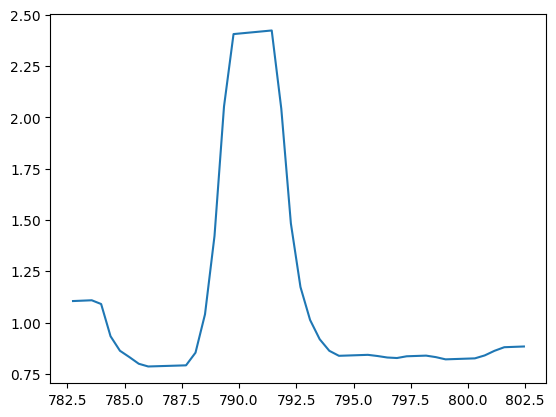

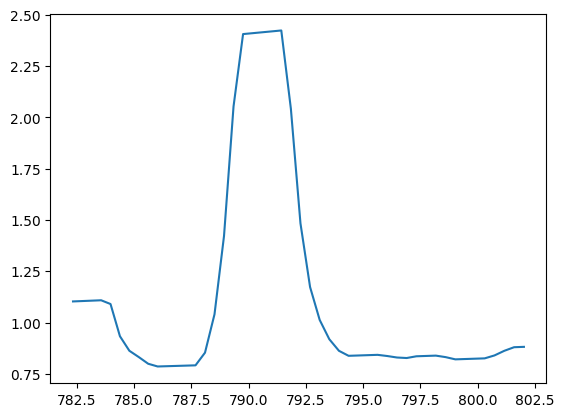

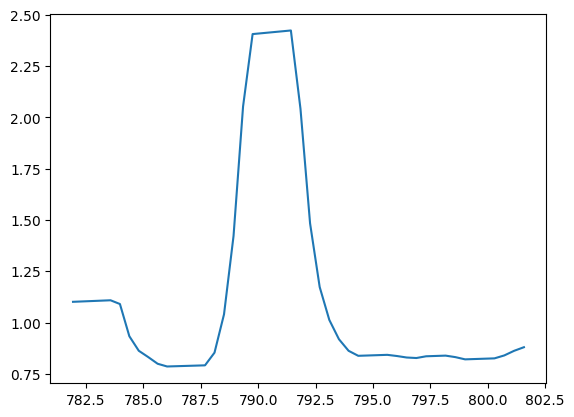

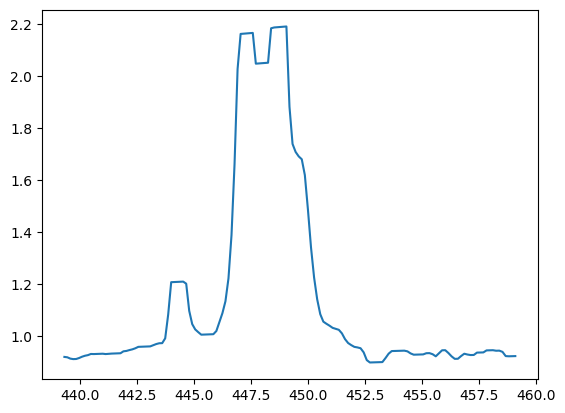

In [25]:
window = 10
for line in line_fs:
    indices = np.where((frequency < (line + window)) & (frequency > (line - window)))
    plt.plot(frequency[indices], intensity_corr[indices])
    plt.show()
# indices